In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from lib.functions import *

In [28]:
###--- Data Generation ---###

### Inference grid defining {ui}i=1,Dx*Dy

def grid(D):
    Dx = D
    Dy = D
    N = Dx * Dy     # Total number of coordinates
    points = [(x, y) for y in np.arange(Dx) for x in np.arange(Dy)]                # Indexes for the inference grid
    coords = [(x, y) for y in np.linspace(0,1,Dy) for x in np.linspace(0,1,Dx)]    # Coordinates for the inference grid
    xi, yi = np.array([c[0] for c in points]), np.array([c[1] for c in points])    # Get x, y index lists
    x, y = np.array([c[0] for c in coords]), np.array([c[1] for c in coords])      # Get x, y coordinate lists
    return N, coords, xi, yi, x, y

N, coords, xi, yi, x, y = grid(16)


## a)

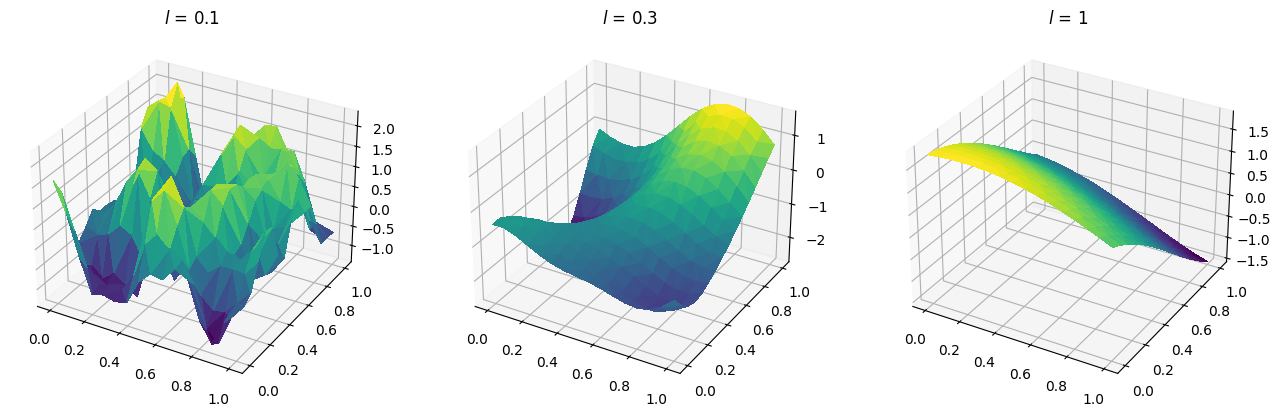

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6), subplot_kw={'projection': '3d'})


for i, l in enumerate([0.1, 0.3, 1]):
    K = GaussianKernel(coords, l)
    Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
    np.random.seed(i + 1)
    plot_3D(Kc @ np.random.randn(N, ), x, y, fig, ax[i], title=f"$l$ = {l}")    
   
plt.show()

# fig.savefig("figures/samples.pdf", dpi=200, bbox_inches='tight')

In [30]:
### Data grid defining {vi}i=1,N/subsample_factor - subsampled from inference grid
subsample_factor = 4
idx = subsample(N, subsample_factor, seed=0)
M = len(idx)                                                                   # Total number of data points

### Generate K, the covariance of the Gaussian process, and sample from N(0,K) using a stable Cholesky decomposition
l = 0.3
K = GaussianKernel(coords, l)
Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
np.random.seed(0)
u = Kc @ np.random.randn(N,) # sample from prior GP

### Observation model: v = G(u) + e,   e~N(0,I)
G = get_G(N, idx)
np.random.seed(9)
noise = np.random.randn(M)
v = G @ u + noise # v = subsample u and add noise

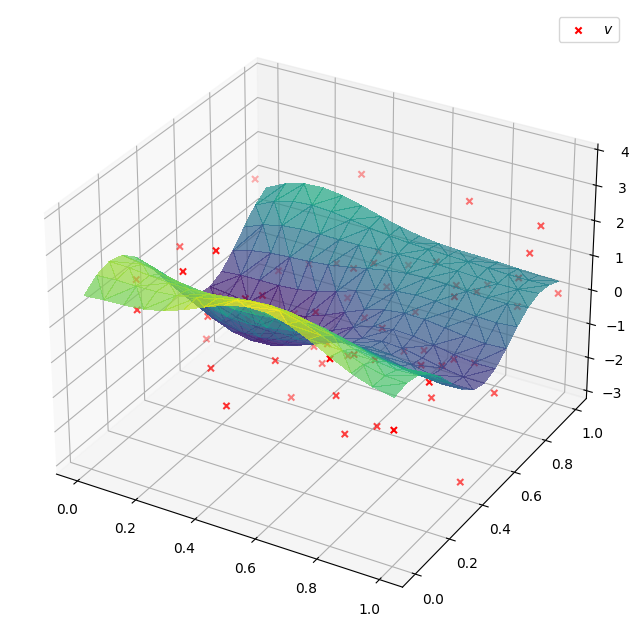

In [31]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
plot_result(u, v, x, y, x[idx], y[idx], fig, ax, legend=True)

# fig.savefig("figures/overlaid.pdf", dpi=200, bbox_inches='tight')

## b)

In [33]:
###--- MCMC ---####

### Set MCMC parameters
n = 20000
beta = 0.2

### Set the likelihood and target, for sampling p(u|v)
log_target = log_continuous_target
log_likelihood = log_continuous_likelihood

### Sample from prior for MCMC initialisation


# TODO: Complete Simulation questions (a), (b).
np.random.seed(4)
X, r = grw(log_target, Kc @ np.random.randn(N, ), v, K, G, n, beta)
print(r)

0.07625


In [34]:
Kc_inverse = np.linalg.inv(Kc)
K_inverse = Kc_inverse.T @ Kc_inverse

sig = K_inverse + G.T @ G

mu = np.linalg.inv(sig) @ G.T @ v

(256,)


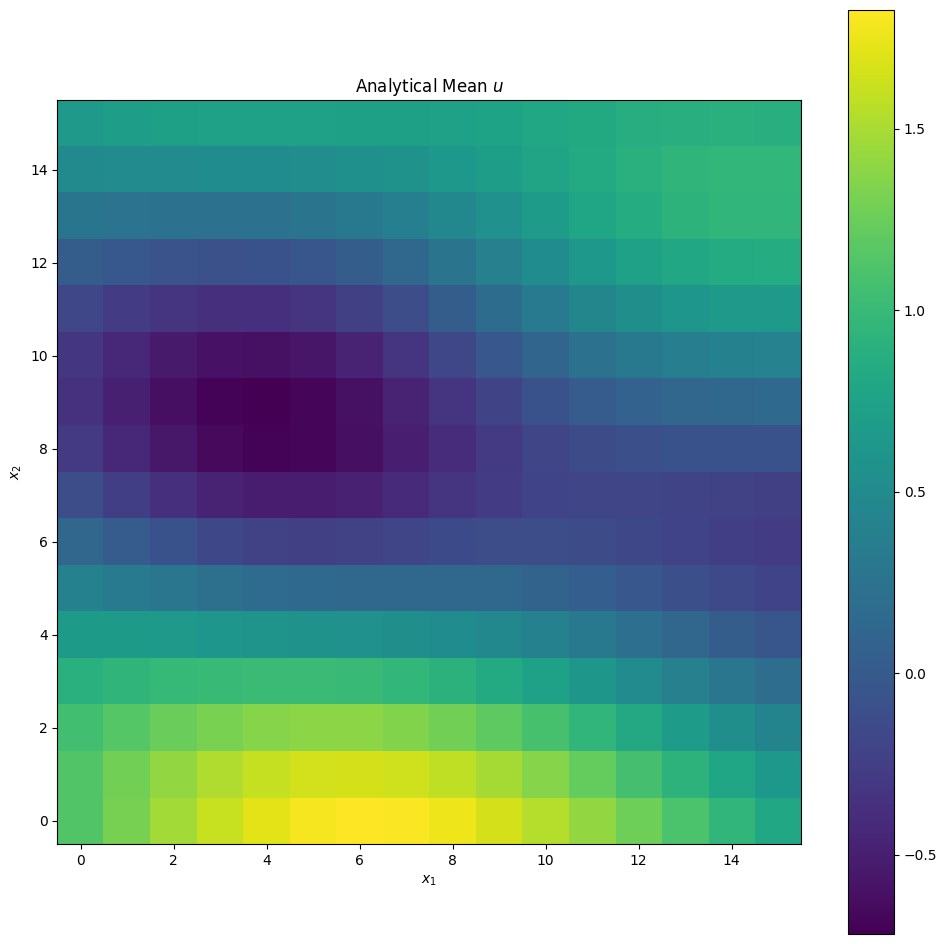

In [35]:
print(mu.shape)
fig, ax = plt.subplots(figsize=(12, 12))

plot_2D(mu, xi, yi, fig, ax, title="Analytical Mean $u$", cbar=1)

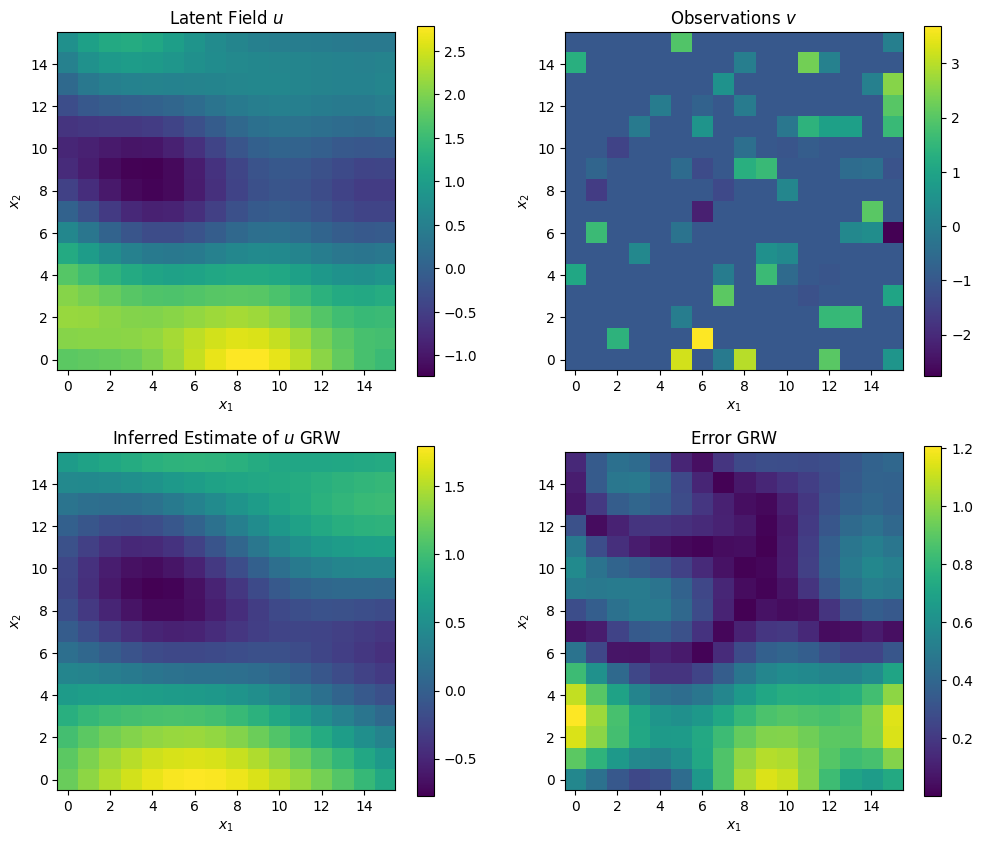

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plot_2D(u, xi, yi, fig, ax[0][0], title="Latent Field $u$", cbar=1)
plot_2D(v, xi[idx], yi[idx], fig, ax[0][1], title="Observations $v$", cbar=1)
plot_2D(np.average(X, axis=0), xi, yi, fig, ax[1][0], title="Inferred Estimate of $u$ GRW", cbar=1)
plot_2D(np.abs(u - np.average(X, axis=0)), xi, yi, fig, ax[1][1], title="Error GRW", cbar=1)

fig.savefig("figures/fit.pdf", dpi=200, bbox_inches='tight')
fig.savefig("media/fit.png", dpi=200, bbox_inches='tight')

plt.show()

In [42]:
np.random.seed(4)
X1, r = pcn(log_likelihood, Kc @ np.random.randn(N, ), v, K, G, n, beta)
print(r)

0.56095


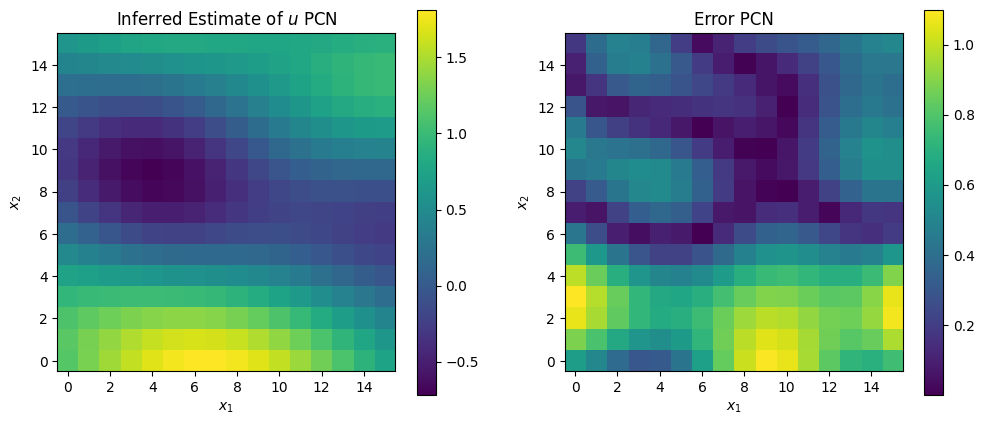

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_2D(np.average(X1, axis=0), xi, yi, fig, ax[0], title="Inferred Estimate of $u$ PCN", cbar=1)
plot_2D(np.abs(u - np.average(X1, axis=0)), xi, yi, fig, ax[1], title="Error PCN", cbar=1)

fig.savefig("figures/fit_pcn.pdf", dpi=200, bbox_inches='tight')

plt.show()

/opt/homebrew/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/lg/yfk8d6kj0d5cqvvjh5kscgym0000gn/T/ipykernel_74448/1937617418.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1.2)


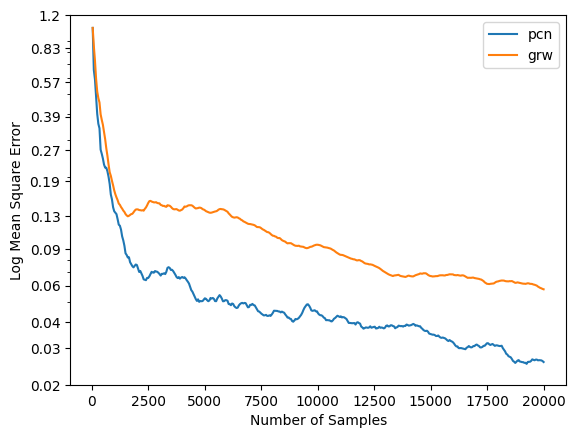

In [44]:
N1 = 50
d2 = np.zeros((2, len(X) // N1))
x = np.linspace(0, 20000, len(X) // N1).astype(int)

for j, i in enumerate(x):
    d2[0, j] = np.std(np.average(X1[:i][::N1], axis=0) - mu)
    d2[1, j] = np.std(np.average(X[:i][::N1], axis=0) - mu)

plt.plot(x, d2[0], label="pcn")
plt.plot(x, d2[1], label="grw")
plt.xlabel("Number of Samples")
plt.ylabel("Log Mean Square Error")
# plt.ylim(0, 0.45)
plt.yscale("log")
plt.ylim(0, 1.2)
xx = np.round(np.geomspace(0.02, 1.2, 12), 2)
plt.yticks(ticks=xx, labels=xx)
plt.legend()
plt.savefig("figures/error.pdf", dpi=200, bbox_inches="tight")
plt.savefig("media/error.png", dpi=200, bbox_inches="tight")
plt.show()

In [40]:
# %%script false --no-raise-error
## -- Varying Beta -- ## 

d = np.zeros((2, 50))

for i, alg in enumerate([(pcn, log_likelihood, "pcn"), (grw, log_target, "grw")]):
    for j, beta in enumerate(np.linspace(0.1, 1, 50)):
        np.random.seed(4)
        Xi, ri = alg[0](alg[1], Kc @ np.random.randn(N, ), v, K, G, n, beta)
        d[i][j] = ri

KeyboardInterrupt: 

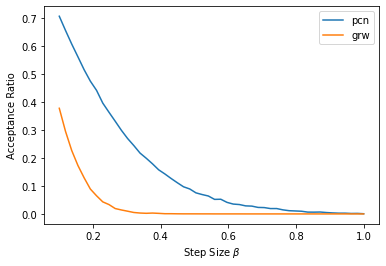

In [ ]:
# %%script false --no-raise-error
## -- Plotting -- ##
for i, name in enumerate(["pcn", "grw"]):
   plt.plot(np.linspace(0.1, 1, 50), d[i], label=name)

plt.xlabel('Step Size $\\beta$')
plt.ylabel('Acceptance Ratio')

plt.legend()
plt.savefig("figures/vary_beta.pdf", dpi=200, bbox_inches="tight")

In [ ]:
%%script false --no-raise-error

dp = 50
fix_m = False

d = np.zeros((2, dp))

for i, alg in enumerate([(pcn, log_likelihood, "pcn"), (grw, log_target, "grw")]):
    for j, D in enumerate(np.linspace(16, 450, dp).astype(int)):
        print(D)

        # if ri < 0.1: continue

        N, coords, xi, yi, x, y = grid(int(np.sqrt(D)))

        subsample_factor = N/16 if fix_m else 4
        idx = subsample(N, subsample_factor, seed=0)
        M = len(idx)

        l = 0.3
        K = GaussianKernel(coords, l)
        Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
        np.random.seed(0)
        u = Kc @ np.random.randn(N,)

        G = get_G(N, idx)
        np.random.seed(0)
        noise = np.random.randn(M)
        v = G @ u + noise 

        np.random.seed(4)
        Xi, ri = alg[0](alg[1], Kc @ np.random.randn(N, ), v, K, G, n, 0.2)
        d[i][j] = ri


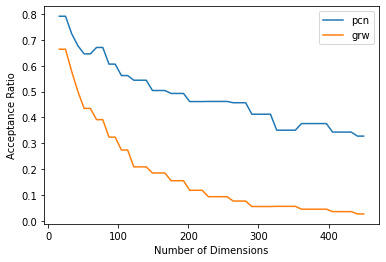

In [ ]:
%%script false --no-raise-error

plt.plot(np.linspace(16, 450, dp), d[0], label="pcn")
plt.plot(np.linspace(16, 450, dp), d[1], label="grw")
plt.xlabel("Number of Dimensions")
plt.ylabel("Acceptance Ratio")
plt.legend()
plt.savefig(f"figures/vary_dim{'_m' if fix_m else ''}.pdf", dpi=200, bbox_inches="tight")
plt.show()

## c)

In [ ]:
N, coords, xi, yi, x, y = grid(16)

subsample_factor = 4
idx = subsample(N, subsample_factor, seed=0)
M = len(idx)

l = 0.3
K = GaussianKernel(coords, l)
Kc = np.linalg.cholesky(K + 1e-6 * np.eye(N))
np.random.seed(0)
u = Kc @ np.random.randn(N,)

G = get_G(N, idx)
np.random.seed(9)
noise = np.random.randn(M)
v = G @ u + noise 

In [ ]:
###--- Probit transform ---###

np.random.seed(4)
X, r = pcn(log_probit_likelihood, Kc @ np.random.randn(N, ), probit(v), K, G, n, beta)
print(r)

0.0125


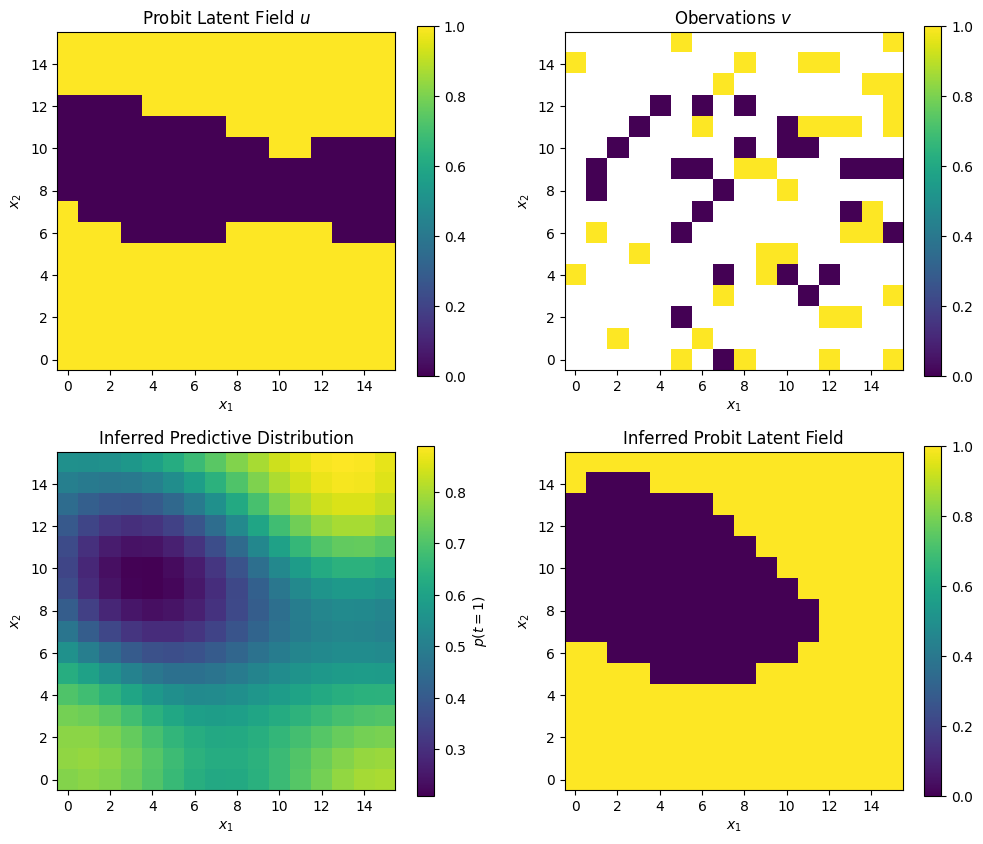

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

plot_2D(probit(u), xi, yi, fig, ax[0, 0], title="Probit Latent Field $u$", cbar=0)
plot_2D(probit(v), xi[idx], yi[idx], fig, ax[0, 1], "Obervations $v$", cbar=0)
plot_2D(predict_t(X), xi, yi, fig, ax[1, 0], title="Inferred Predictive Distribution", cbar="$p(t=1)$")
plot_2D(predict_t(X) > 0.5, xi, yi, fig, ax[1, 1], title="Inferred Probit Latent Field", cbar=0)

fig.savefig("figures/probit.pdf", dpi=200, bbox_inches='tight')

plt.show()

relatively poor inference, quality of the inference is variable due to the random noise and sub sample, might get a better idea trying multiple subsample and noise

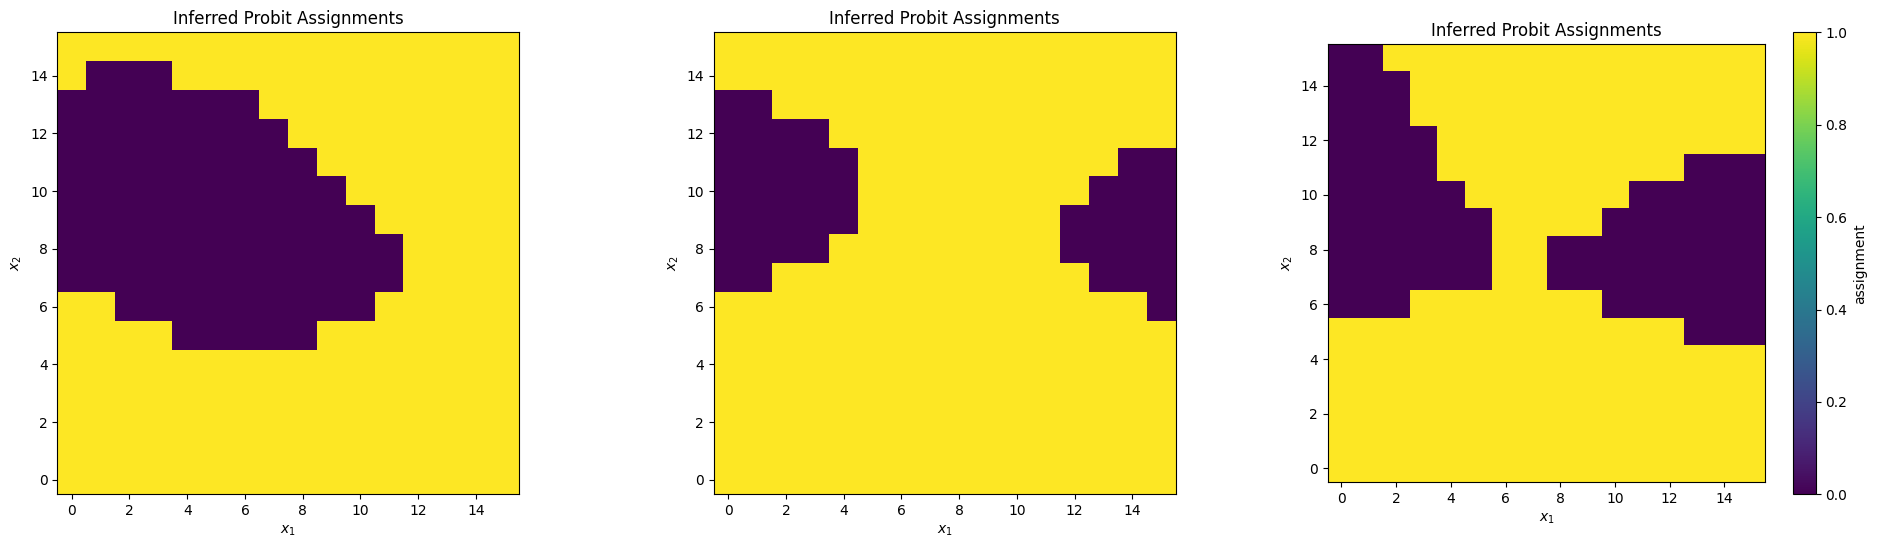

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

for i in range(3):
    idx = subsample(N, subsample_factor, seed=8*i)
    np.random.seed(9 + 4*i)
    noise = np.random.randn(M)
    v = G @ u + noise 

    np.random.seed(4)
    X, r = pcn(log_probit_likelihood, Kc @ np.random.randn(N, ), probit(v), K, G, n, beta)

    plot_2D(predict_t(X) > 0.5, xi, yi, fig, ax[i], title="Inferred Probit Assignments", cbar="assignment" if i == 2 else None)

plt.show()

## d)

In [ ]:
def error(u, X):
    return np.mean(np.abs((probit(u) - (predict_t(X) > 0.5))))

In [ ]:
steps = 100
d = np.zeros(steps)

In [ ]:
for i, l in enumerate(np.logspace(-2, 1, steps)):
    K = GaussianKernel(coords, l)
    np.random.seed(4)
    X, r = pcn(log_probit_likelihood, Kc @ np.random.randn(N, ), probit(v), K, G, n, beta)
    d[i] = error(u, X)

KeyboardInterrupt: 

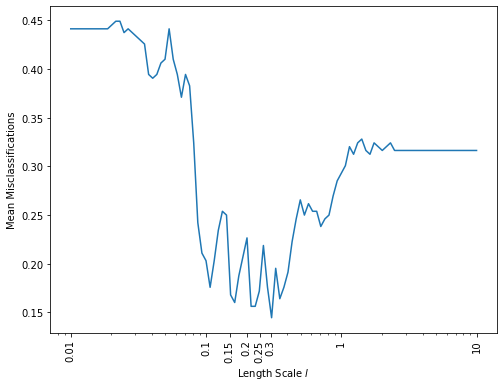

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.logspace(-2, 1, steps), d)
ax.set_ylabel("Mean Misclassifications")
ax.set_xlabel("Length Scale $l$")
ax.set_xscale("log")
ax.set(xticks=[0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 1, 10])
ax.set_xticklabels([0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 1, 10], rotation=90)

fig.savefig("figures/optimisation.pdf", dpi=200, bbox_inches='tight')

plt.show()

Minimum error, $l$ = 0.24. The actual length scale for generation was 0.3 so it has been inferred fairly well. The noise added to the data is completely uncorrelated between neighbours, this will have the effect of decreasing the inferred length scale (see samples in part a). This corresponds as 0.24 is an under estimate of the generation length scale.